In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization as tq


from torchvision import transforms,datasets

from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import time


In [19]:
# data preparation

transform=transforms.Compose([
    transforms.Resize((32, 32)),transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

entire=datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

test=datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

train_size=int(0.8*len(entire))
valid_size=len(entire)-train_size

train_data, valid_data=random_split(entire, [train_size, valid_size])

train_loader=DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=64, shuffle=False)
test_loader= DataLoader(test, batch_size=64, shuffle=False)

#print(len(train_data), len(valid_data), len(test))


In [20]:
#Model Design

class CIFARCNN(nn.Module):
    def __init__(self):
        super(CIFARCNN, self).__init__()
    #initial set 3*32*32
    #conv --> output(32)=(input(32)-kernal(3)+2*padding)/stride(1) +1 <-padding 1
        self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
    #maintain size, put padding=1
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3, padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
#divide vertical/parallel half 32*32->16*16
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1)
#128 filter, each feature map size 8*8
        self.fc1=nn.Linear(in_features=128*8*8,out_features=256)
        self.fc2=nn.Linear(in_features=256,out_features=10)

    def forward(self, x):
        x=self.pool(torch.relu(self.conv2(torch.relu(self.conv1(x)))))
        #feature map 32*32->16*16
        x=self.pool(torch.relu(self.conv4(torch.relu(self.conv3(x)))))
        #feature map 16*16->8*8
        x=x.view(-1, 128*8*8) #-1 <-automatically calculate batch size
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CIFARCNN()


In [21]:
#Training

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#loss, accuracy 
epochs = 10
train_losses,valid_losses=[], []
train_accs, valid_accs=[], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0 #initialization
    for images, labels in train_loader:
        outputs=model(images)
        loss=criterion(outputs, labels)

        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

        running_loss+=loss.item() 
        _, pred = torch.max(outputs, dim=1)
        total+=labels.size(0)
        correct+=(pred == labels).sum().item()

    train_losses.append(running_loss/len(train_loader))
    train_accs.append(correct/total)

    model.eval()
    valid_loss,valid_correct,valid_total=0,0,0

    with torch.no_grad():
        for images, labels in valid_loader:
            out=model(images)
            loss=criterion(out, labels)

            valid_loss+=loss.item()
            _, pred=torch.max(out, dim=1)
            valid_total+=labels.size(0)
            valid_correct+=(pred == labels).sum().item()

    valid_losses.append(valid_loss / len(valid_loader))
    valid_accs.append(valid_correct / valid_total)

    print(f"Epoch {epoch}" f": Train Acc={train_accs[-1]:.4f}, Val Acc={valid_accs[-1]:.4f}")


Epoch 0: Train Acc=0.5009, Val Acc=0.6034
Epoch 1: Train Acc=0.6793, Val Acc=0.6982
Epoch 2: Train Acc=0.7591, Val Acc=0.7339
Epoch 3: Train Acc=0.8190, Val Acc=0.7414
Epoch 4: Train Acc=0.8733, Val Acc=0.7451
Epoch 5: Train Acc=0.9202, Val Acc=0.7417
Epoch 6: Train Acc=0.9454, Val Acc=0.7463
Epoch 7: Train Acc=0.9592, Val Acc=0.7413
Epoch 8: Train Acc=0.9677, Val Acc=0.7418
Epoch 9: Train Acc=0.9710, Val Acc=0.7433


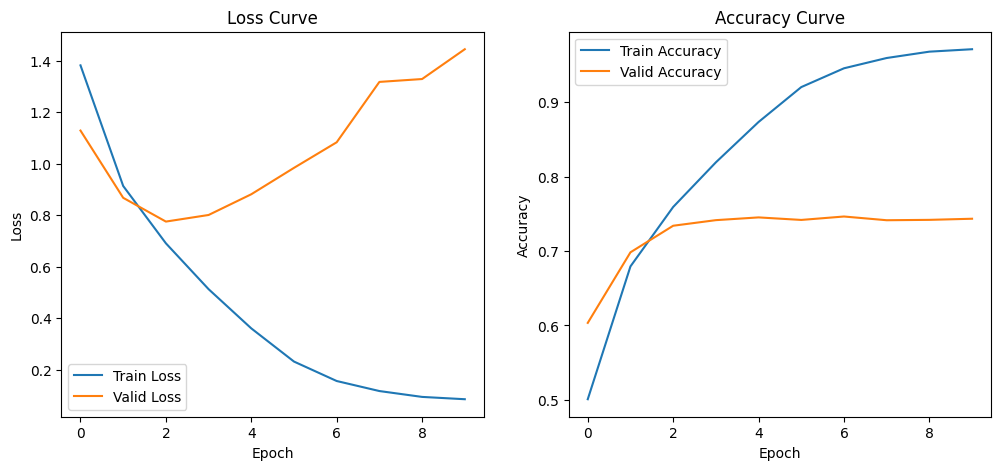

In [22]:
#curve
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(valid_accs, label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


In [23]:
# Final Test Accuracy

model.eval()
correct,total=0,0

with torch.no_grad():
    for images, labels in test_loader:
        out=model(images)
        _, pred=torch.max(out, dim=1)
        total+=labels.size(0)
        correct+=(pred == labels).sum().item()
test_acc=correct / total
print("Final Test Accuracy:", test_acc)


Final Test Accuracy: 0.7467


In [24]:
#Quantization, using quantize_dynamic

quantized_model = tq.quantize_dynamic(
    model,{nn.Linear}, dtype=torch.qint8 )

#quantized_model



C:\Users\zuiga\AppData\Local\Temp\ipykernel_18192\1230790759.py:3: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = tq.quantize_dynamic(


In [25]:
# Model size comparison

import os

torch.save(model.state_dict(), "Original.pth")
torch.save(quantized_model.state_dict(), "Quantized.pth")

original_size=os.path.getsize("Original.pth")/1024
quantized_size=os.path.getsize("Quantized.pth")/1024

print(f"Original Model Size: {original_size:.1f} KB")
print(f"Quantized Model Size: {quantized_size:.1f} KB")

Original Model Size: 9148.3 KB
Quantized Model Size: 2998.2 KB


In [26]:
#Quantized Model Accuracy

quan_correct,quan_total=0,0

with torch.no_grad():
    for images, labels in test_loader:
        out=quantized_model(images)
        _, pred=torch.max(out, 1)
        quan_total+=labels.size(0)
        quan_correct+=(pred == labels).sum().item()

quan_acc=quan_correct / quan_total
print("Quantized Model Test Accuracy:", quan_acc)


Quantized Model Test Accuracy: 0.747


In [27]:
# Inference Time Comparison

def inference_time(model):
    model.eval()
    start=time.time()
    with torch.no_grad():
        for images, _ in test_loader:
            _ =model(images)
    end=time.time()
    
    return end-start

original_time=inference_time(model)
quantized_time=inference_time(quantized_model)

print("Original Inference Time:", original_time)
print("Quantized Inference Time:", quantized_time)


Original Inference Time: 22.74093723297119
Quantized Inference Time: 22.490966796875
